# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

      crim    zn  indus  chas    nox     rm   age     dis  rad    tax  \
0  0.15876   0.0  10.81   0.0  0.413  5.961  17.5  5.2873  4.0  305.0   
1  0.10328  25.0   5.13   0.0  0.453  5.927  47.2  6.9320  8.0  284.0   
2  0.34940   0.0   9.90   0.0  0.544  5.972  76.7  3.1025  4.0  304.0   
3  2.73397   0.0  19.58   0.0  0.871  5.597  94.9  1.5257  5.0  403.0   
4  0.04337  21.0   5.64   0.0  0.439  6.115  63.0  6.8147  4.0  243.0   

   ptratio   black  lstat  medv  
0     19.2  376.94   9.88  21.7  
1     19.7  396.90   9.22  19.6  
2     18.4  396.24   9.97  20.3  
3     14.7  351.85  21.45  15.4  
4     16.8  393.97   9.43  20.5  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     404 non-null    float64
 1   zn       404 non-null    float64
 2   indus    404 non-null    float64
 3   chas     404 non-null    float64
 4   nox      404 non-nu

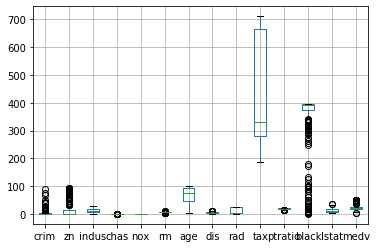

In [1]:
# Your code here
import pandas as pd
data=pd.read_csv('../data/boston_data.csv')
print(data.head())
print(data.info())
data.boxplot()


### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

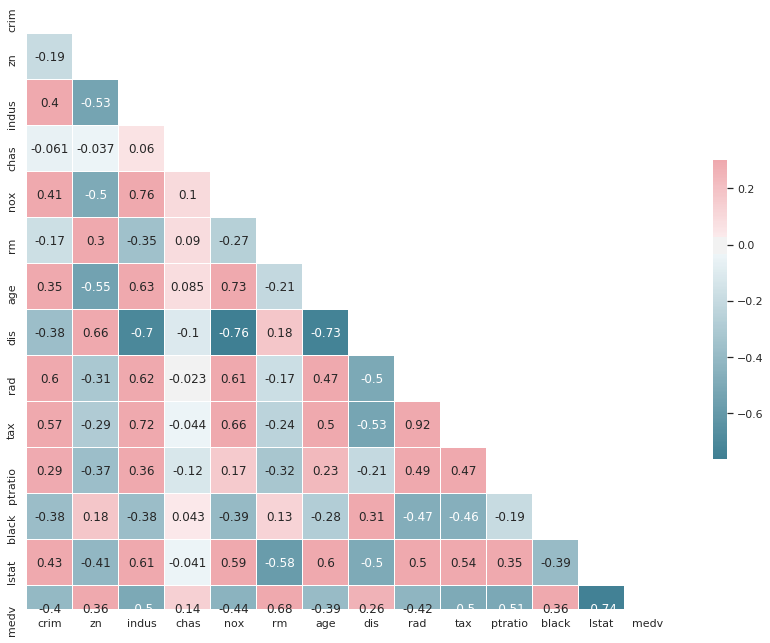

In [4]:
# Your plots here


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def heatmap_f(dataframe):

    corr = dataframe.corr()

    sns.set(style="white")

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 11))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})
    return plt.show()


heatmap_f(data)



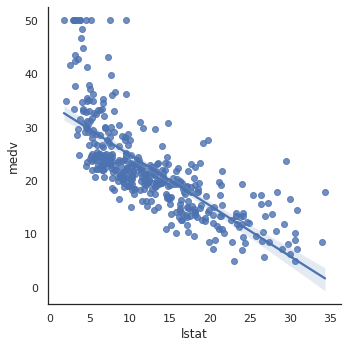

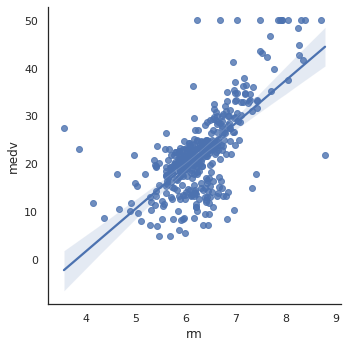

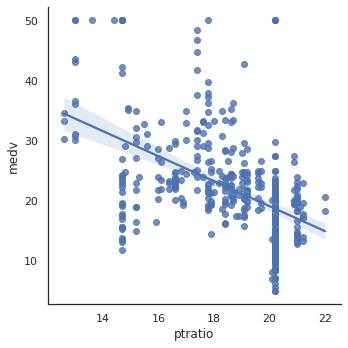

In [5]:
sns.lmplot(x='lstat',y='medv',data=data,fit_reg=True)
plt.show()
sns.lmplot(x='rm',y='medv',data=data,fit_reg=True)
plt.show()
sns.lmplot(x='ptratio',y='medv',data=data,fit_reg=True)
plt.show()

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [ ]:
# Your response here
# LSTAT has a negative correlation with MEDV. Sounds correct. Lower status pop = cheaper housing 
# RM has a positive correlation as expected since RM is the numbers of rooms in the dwelling. More rooms = More $
# PTRATION has a negative correlation with MEDV as expected. High values of PTRATIOS means areas with reduce numbers of teachers for each student so it is an area with less demand therefore cheaper


### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

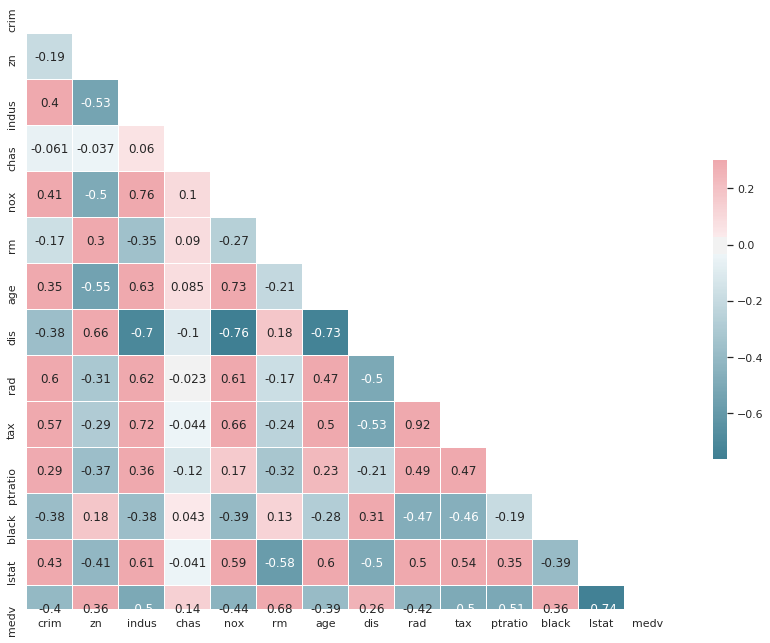

indus, tax and nox have high correlation


In [6]:
# Your response here
heatmap_f(data)

print("indus, tax and nox have high correlation")

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [7]:
# Your code here


data['medv'].describe()



count    404.000000
mean      22.312376
std        8.837019
min        5.000000
25%       17.100000
50%       21.400000
75%       25.000000
max       50.000000
Name: medv, dtype: float64

----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [8]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    # Your code here:
    return r2_score(y_true, y_predict)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [9]:
# Your code here
from sklearn.model_selection import train_test_split

X = data.drop('medv', axis=1)
y = data['medv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True) #shuffle parameter dafault is True!


----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [17]:


from sklearn.ensemble import RandomForestRegressor
max_depth=[1,2,4,6,8,10]

scores_train={}
scores_test={}

for i in max_depth:
    model = RandomForestRegressor(n_estimators=10, max_depth=i, n_jobs=-1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores_test[i]=performance_metric(y_test, y_pred)
    scores_train[i]=performance_metric(y_train,model.predict(X_train))

print(scores_train)
print(scores_test)

{1: 0.5732037490069641, 2: 0.7671307659581154, 4: 0.909283300070344, 6: 0.9513192089774122, 8: 0.9661059407701011, 10: 0.9701583864941874}
{1: 0.5653648596036989, 2: 0.7681042310889267, 4: 0.8206444334278604, 6: 0.8494790198289868, 8: 0.8385216059143246, 10: 0.8378730357974861}


Now, plot the score for each tree on the training set and on the testing set.

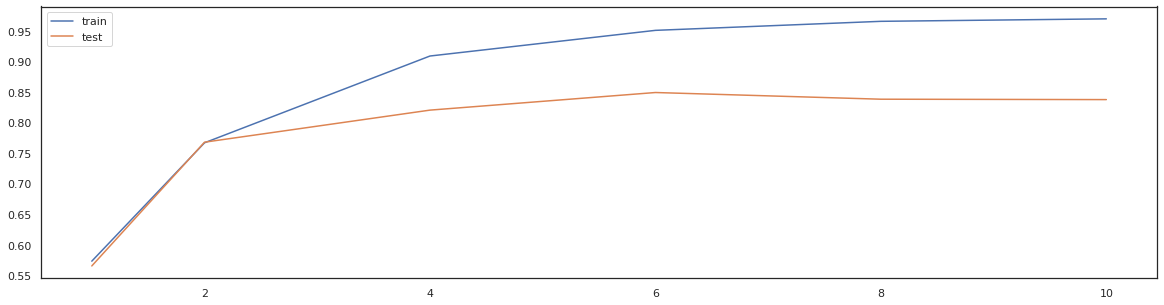

In [25]:
# Produce a plot with the score for the testing and training for the different max depths
plt.figure(figsize=(20,5))
plt.plot(list(scores_train.keys()),list(scores_train.values()),label="train")
plt.plot(list(scores_test.keys()),list(scores_test.values()),label="test")
plt.legend()
plt.show()



What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [26]:
# We see that our model overfits for larger depth value

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10? Check out this article before answering: https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229

What is bias?

Bias is the difference between the average prediction of our model and the correct value which we are trying to predict. Model with high bias pays very little attention to the training data and oversimplifies the model. It always leads to high error on training and test data.

What is variance?

Variance is the variability of model prediction for a given data point or a value which tells us spread of our data. Model with high variance pays a lot of attention to training data and does not generalize on the data which it hasn’t seen before. As a result, such models perform very well on training data but has high error rates on test data.


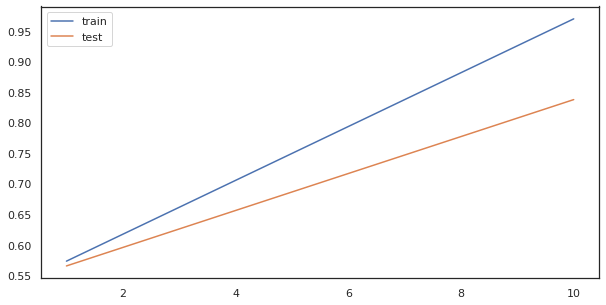

THE MODEL WITH DEPTH = 1 HAS HIGH BIAS. High error on training and test data.

THE MODEL WITH DEPTH = 10 HAS A MODERATE HIGH VARIANCE. Good performance on training data with not so good accuracy in test data.


In [27]:
# Your response here

print("""What is bias?

Bias is the difference between the average prediction of our model and the correct value which we are trying to predict. Model with high bias pays very little attention to the training data and oversimplifies the model. It always leads to high error on training and test data.

What is variance?

Variance is the variability of model prediction for a given data point or a value which tells us spread of our data. Model with high variance pays a lot of attention to training data and does not generalize on the data which it hasn’t seen before. As a result, such models perform very well on training data but has high error rates on test data.""")

plt.figure(figsize=(10,5))
plt.plot([1,10],[scores_train[1],scores_train[10]],label="train")
plt.plot([1,10],[scores_test[1],scores_test[10]],label="test")
plt.legend()
plt.show()


print('THE MODEL WITH DEPTH = 1 HAS HIGH BIAS. High error on training and test data.' )
print("")
print( 'THE MODEL WITH DEPTH = 10 HAS A MODERATE HIGH VARIANCE. Good performance on training data with not so good accuracy in test data.')

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [28]:
# Your response here


#I would go for max_depth = 6 even with mid/high variance values



### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [29]:
# Your response here
#Not relevant
#No
#I don't think so. Small train dataset
#No
